# Learning interaction potentials and energy-conserving force fields
Dr. Tristan Bereau (HIMS & IvI, UvA; t.bereau@uva.nl)

Tutorial together with Kiran H. Kanekal (Max Planck Inst for Polymer Research)

Oct 2020

This tutorial aims at giving you some basics on embedding physics in machine learning (ML) models. We'll use kernel-based Gaussian process regression (GPR) models for ease of use, since they can easily be implemented using not much more than the `numpy` library.

We will focus on two aspects:
1. Learning a Lennard-Jones potential. This seemingly trivial example of learning a 1D function already demonstrates the usefulness of adding a physically motivated prior.
1. Learning an energy conserving force field. We will compare several kernels, from a naïve implementation that does not ensure energy conservation, to two approaches that do ensure energy conservation. The comparison will be made on a two-dimensional double well potential.

## Lennard-Jones potential

The Lennard-Jones potential, $U_{\rm LJ}(r)$, is a cornerstone of intramolecular interactions. It's a numerically efficient potential to incorporate both short-range repulsion and attractive London dispersion (also called van der Waals interactions). We will define it as a function of the interatomic distance, $r$, and in reduced units of length, $\mathcal{L}$, and energy, $\mathcal{E}$:

In [ ]:
def lj(r):
    return 4. * ((1./r)**12 - (1./r)**6)

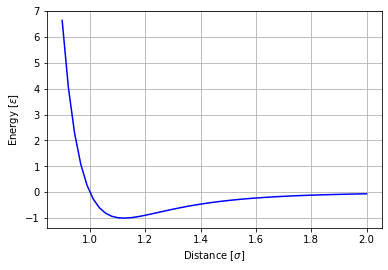

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dists = np.linspace(0.9, 2.0, 50)

plt.plot(dists, lj(dists), 'b')
plt.grid()
plt.xlabel('Distance [$\sigma$]')
plt.ylabel('Energy [$\epsilon$]');

We want to learn this potential from discrete samples. We'll randomly select points on the interval `dists`. For good practice, we'll split our data between training and test using the `sklearn` package. For now we simply plot two arbitrarily chosen sets of points, for illustration purposes. The GPR will aim at inferring the green dots from the red ones, as best as it can.

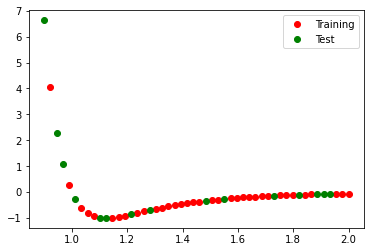

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(dists, train_size=0.7, shuffle=True)

plt.plot(X_train, lj(X_train), 'or', label='Training')
plt.plot(X_test, lj(X_test), 'og', label='Test')
plt.legend();

### Implementation of a GPR

We need the following ingredients:
- a representation, the distance $r$.  To follow common notation in ML textbooks, we will call the vector of input samples $X = \{x_1, x_2, \dots \}$.
- a target property, the energy $U_{\rm LJ}(r)$. In the code we'll call the target property $y$.
- a metric, we'll choose a Laplacian kernel with $l^2$ norm 
$$
  K(r,r') = \exp \left( - \frac{||r-r' ||^1_2}{\sigma} \right)
$$
to compute the distance between input samples $r$ and $r'$.
To build the matrix $K$ efficiently we'll take advantage of a couple `scipy` routines.

Learning a GPR from $N$ training points then consists of inverting the regularized matrix equation $U = \alpha (K + \lambda I)$, where $\alpha$ is the set of optimized weights, $\lambda$ is the regularization hyperparameter, and $I$ is the identity matrix. Both $K$ and $I$ are of size $(N \times N)$, while $\alpha$ is a vector of size $N$. 

Training our ML model really boils down to optimizing the coefficients $\alpha$. Once we have them, we can deploy the ML model to a new input point $r$:
$$
  U(r) = \sum_i^N \alpha_i K(r^*_i, r)
$$
where $r^*_i$ is one of the $N$ training inputs.

In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics import mean_absolute_error

class GPR:
  def __init__(self, sigma, lambd):
    self.sigma = sigma
    self.lambd = lambd
    self.alpha = []
    self.X_train = []
    self.y_train = []

  def add_training(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def build_matrix(self, X1, X2):
    return np.exp( - cdist(X1, X2, 'euclidean') / self.sigma)

  def train_model(self):
    matrix = self.build_matrix(self.X_train,self.X_train) \
            + self.lambd * np.identity(len(self.X_train))
    self.alpha = np.dot(self.y_train, np.linalg.inv( matrix ))
  
  def predict_model(self, X_pred):
    return np.dot( self.alpha, self.build_matrix(self.X_train, X_pred))

  def return_mae(self, X_pred, y_ref):
    return mean_absolute_error(y_ref, self.predict_model(X_pred))

Let's try it out! We'll make use of the train/test split covered earlier to train our ML model, deploy it on the test set, and compute the mean absolute error (MAE):

MAE on energy predictions of test set: 0.04122248068122864


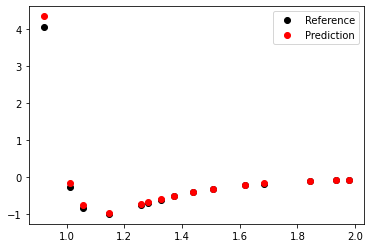

In [ ]:
X_train, X_test = train_test_split(dists, train_size=0.7, shuffle=True)
y_train, y_test = lj(X_train), lj(X_test)
X_train, X_test = X_train.reshape((len(X_train),1)), \
                  X_test.reshape((len(X_test),1))
gpr = GPR(sigma=0.1, lambd=1e-9)
gpr.add_training(X_train, y_train)
gpr.train_model()
print("MAE on energy predictions of test set:",gpr.return_mae(X_test, y_test))
plt.plot(X_test, y_test, 'ok', label="Reference")
plt.plot(X_test, gpr.predict_model(X_test), 'or', label="Prediction")
plt.legend();

To more quantitatively assess how efficiently the ML model is learning, let's compute a learning curve: the mean absolute error as a function of training-set size. We'll do this by averaging several ML models for a number of training set sizes.

In [ ]:
import scipy

class AnalyzeMLModel:
  def __init__(self, X_input, y_input, N_training, gpr):
    self.gpr = gpr
    self.X   = X_input
    self.y   = y_input
    self.n   = N_training

  def run(self, number_models):
    maes = []
    for i in range(number_models):
      # Evaluate maximum 10,000 points
      idxs = np.random.randint(0, len(self.y), min(10000, len(self.y)))
      frac = self.n/len(idxs)
      X_train, X_test, y_train, y_test = \
          train_test_split(self.X[idxs], self.y[idxs], 
                           train_size=frac, shuffle=True)
      self.gpr.add_training(X_train.reshape((len(X_train),1)), 
                            y_train)
      self.gpr.train_model()
      maes.append(self.gpr.return_mae(
          X_test.reshape((len(X_test),1)), y_test))
    # Return mean and error of the mean
    return np.mean(maes), scipy.stats.sem(maes) #np.std(maes) for standard deviation

In [ ]:
numdata = [2,5,10,20,50,100,200,500,1000]
maes = []
X_input = np.linspace(0.85, 2.0, 2000)
y_input = lj(X_input)
for n in numdata:
  analysis = AnalyzeMLModel(X_input, y_input, n, GPR(0.1, 1e-9))
  maes.append(analysis.run(20))
maes = np.asarray(maes)

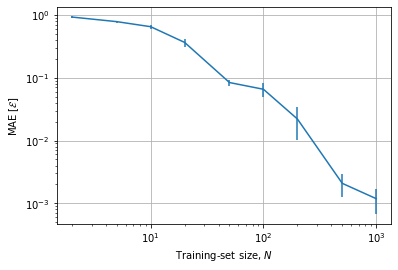

In [ ]:
plt.errorbar(numdata, maes.T[0], yerr=maes.T[1])
plt.xlabel("Training-set size, $N$")
plt.ylabel("MAE [$\mathcal{E}$]")
plt.loglog()
plt.grid();

### Adding a prior to the potential

Often predictions on the potential badly fail at short range, due to difficulties in reproducing the divergence. To alleviate this, let's implement a simple linear repulsive prior of the form 
$$
U_{\rm prior} = - \gamma (r-r_0) \theta(r_0-r)
$$
where $\gamma$ and $r_0$ are new hyperparameters. $\gamma$ controls the slope and $r_0$ the range of the function, while $\theta$ denotes the Heaviside step function (i.e., returns 0 if the arguments is negative). We'll simply redefine relevant methods of the class `GPR` in the new inherited `GPRwPrior`.

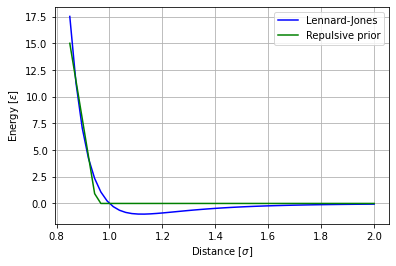

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dists = np.linspace(0.85, 2.0, 50)

def prior_rep(r, gamma, r0):
  return -gamma*(r-r0)*np.heaviside(r0-r, 0.)

plt.plot(dists, lj(dists), 'b', label="Lennard-Jones")
plt.plot(dists, prior_rep(dists, 150., 0.95,), 'g', label="Repulsive prior")
plt.grid()
plt.xlabel('Distance [$\sigma$]')
plt.ylabel('Energy [$\epsilon$]')
plt.legend();

In [ ]:
class GPRwPrior(GPR):
  def __init__(self, sigma, lambd, gamma, r_0):
    GPR.__init__(self, sigma, lambd)
    self.gamma = gamma
    self.r_0   = r_0

  def prior(self, r):
    return -self.gamma*(r-self.r_0)*np.heaviside(self.r_0 - r, 0.)

  def add_training(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train - self.prior(X_train.T[0])
  
  def predict_model(self, X_pred):
    return self.prior(X_pred.T[0]) + np.dot( self.alpha, self.build_matrix(self.X_train, X_pred))

In [ ]:
maes_w_prior = []
X_input = np.linspace(0.85, 2.0, 2000)
y_input = lj(X_input)
for n in numdata:
  analysis = AnalyzeMLModel(X_input, y_input, n,
                            GPRwPrior(sigma=0.1, lambd=1e-7, gamma=150, r_0=0.95))
  maes_w_prior.append(analysis.run(20))
maes_w_prior = np.asarray(maes_w_prior)

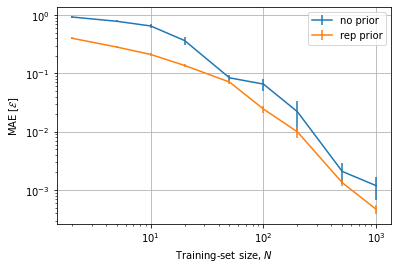

In [ ]:
plt.errorbar(numdata, maes.T[0], yerr=maes.T[1], label='no prior')
plt.errorbar(numdata, maes_w_prior.T[0], yerr=maes_w_prior.T[1], label='rep prior')
plt.xlabel("Training-set size, $N$")
plt.ylabel("MAE [$\mathcal{E}$]")
plt.loglog()
plt.legend()
plt.grid();

Learning with this simple repulsive prior leads to improved learning performance: while the slope (i.e., learning rate) is roughly the same, the offset is significantly reduced. Note that this is a log-log plot. 

Statistical information theory predicts that ML models often learn with a power-law behavior between test error and training-set size
$$
  E \sim \beta N^\nu
$$
where the coefficients $\beta$ and $\nu$ dictate the offset and slope of learning, respectively. See papers from Vapnik et al. for more details.


---
## Learning energy-conserving force fields

Next up, we'll be learning a force field. We'll introduce concepts of energy conservation, but also covariance. A force is a vector, which has a direction. This direction changes together with rotation of the input sample, that's covariance. We'll look at this from the point of view of a particle in a two-dimensional double-well potential. The potential can be found in Wang et al., ACS Cent. Sci. 2019, 5, 755−767.

2D Potential:
$$
\frac{V(x,y)}{k_{\rm B}T} = \frac 1{50} (x-4) (x-2) (x+2) (x+3) + \frac 1{20}y^2 + \frac 1{25} \sin(3(x+5)(y-6)).
$$

Instead of the potential energy, we'll be learning components of the force. The potential leads to a force along $x$:
$$
 \frac{\partial V}{\partial x} = \frac 1{50} (4x^3 - 3x^2-32x+4) + \frac 3{25}(y-6)\cos(3(x+5)(y-6)).
$$
and the force along $y$
$$
 \frac{\partial V}{\partial y} = \frac 1{10}y + \frac 3{25}(x+5)\cos(3(x+5)(y-6)).
$$


In [ ]:
class Potential2D:
  def energy(self, x, y):
    return 1/50.*(x-4)*(x-2)*(x+2)*(x+3) \
        + 1/20. * y**2 + 1/25.*np.sin(3*(x+5)*(y-6))

  def dUdx(self, x, y):
    return 1/50.*(4*x**3 - 3*x**2-32*x+4) \
            + 3/25.*(y-6)*np.cos(3*(x+5)*(y-6))

  def dUdy(self, x, y):
    return 1/10.*y + 3/25. *(x+5)*np.cos(3*(x+5)*(y-6))

The potential and two components of the force looks like the following

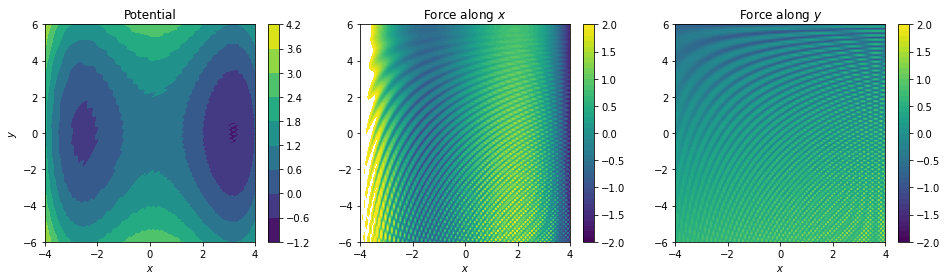

In [ ]:
X = np.linspace(-4,4,100)
Y = np.linspace(-6,6,100)
potential = Potential2D()
R = np.array([[x,y] for x in X for y in Y])
Z_pot, Z_fx, Z_fy = np.outer(X,Y), np.outer(X,Y), np.outer(X,Y)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
vmin, vmax = -2, 2
levels = np.linspace(vmin, vmax, 41)
for x in range(len(X)):
    Z_pot[:,x] =  potential.energy(X[x],Y)
    Z_fx[:,x]  = -potential.dUdx(X[x],Y)
    Z_fy[:,x]  = -potential.dUdy(X[x],Y)
im1 = ax1.contourf(X,Y,Z_pot)
im2 = ax2.contourf(X,Y,Z_fx, levels=levels, vmin=vmin, vmax=vmax)
im3 = ax3.contourf(X,Y,Z_fy, levels=levels, vmin=vmin, vmax=vmax)
ax1.set_title('Potential')
ax2.set_title('Force along $x$')
ax3.set_title('Force along $y$')
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
ax3.set_xlabel('$x$')
ax1.set_ylabel('$y$')
cbar = fig.colorbar(im1, ax=ax1)
cbar = fig.colorbar(im2, ax=ax2)
cbar = fig.colorbar(im3, ax=ax3);

### Data generation

Since we have access to the potential and its derivatives, we can simply generate data of a particle diffusing on this surface using Brownian (overdamped) dynamics.

In [ ]:
class BrownianDynamics2D:
  def __init__(self, potential, temperature, diffusion_coefficient, time_step):
    self.pot  = potential
    self.kT   = temperature
    self.diff = diffusion_coefficient
    self.dt   = time_step
    self.x    = 0.
    self.y    = 0.
    self.data_x  = []
    self.data_y  = []
    self.data_fx = []
    self.data_fy = []

  def integrate(self, step):
    # We'll store force data that we sample
    self.data_x[step] = self.x
    self.data_y[step] = self.y
    fx, fy = -self.pot.dUdx(self.x, self.y), -self.pot.dUdy(self.x, self.y)
    self.data_fx[step] = fx
    self.data_fy[step] = fy
    self.x += self.diff * self.dt * fx / self.kT \
            + 1.4142135623730951 * np.sqrt(self.diff * self.dt) * np.random.randn()
    self.y += self.diff * self.dt * fy / self.kT \
            + 1.4142135623730951 * np.sqrt(self.diff * self.dt) * np.random.randn()
  
  def integrate_n(self, n_steps):
    self.data_x, self.data_y = np.zeros(n_steps), np.zeros(n_steps)
    self.data_fx, self.data_fy = np.zeros(n_steps), np.zeros(n_steps)
    for i in range(n_steps):
      self.integrate(i)

In [ ]:
potential = Potential2D()
dyn = BrownianDynamics2D(potential, 1.0, 100., 1e-5)
dyn.integrate_n(1000000)

Integrating the model will take a few moments... we need to integrate the Brownian dynamics model enough steps to overcome the large energy barrier and allow crossing. We'll later subsample the data for train/test dataset. 

Once this is done we can look at the histogram of the coordinates sampled

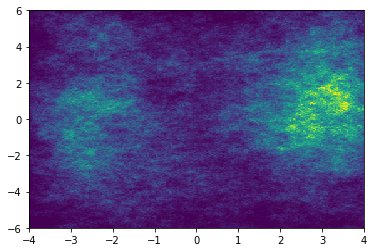

In [ ]:
plt.hist2d(dyn.data_x, dyn.data_y, bins=(200, 200), range=((-4,4), (-6,6)))
plt.show()

### ML approach 1: learn the two components independently

We'll work with a Gaussian (or radial-basis function) kernel this time
$$
  K(q,q') = \exp\left(-\frac{(q - q')^2}{2\sigma^2}\right).
$$
Here, $q$ represents one of the two spatial coordinates, $x$ or $y$.

We'll solve the kernels independently for the two components: 
- solve $f^x_j = \sum_i \alpha^x_i K(q_i,q_j)$;
- solve $f^y_j = \sum_i \alpha^y_i K(q_i,q_j)$.


In [ ]:
class GPRrbf(GPR):
  def build_matrix(self, X1, X2):
    return np.exp( - cdist(X1, X2, 'euclidean')**2 / (2.*self.sigma**2) )

In [ ]:
numdata = [2,4,10,20,50,100,200,500,1000]
maes_x, maes_y = [], []
for n in numdata:
  analysis = AnalyzeMLModel(dyn.data_x, dyn.data_fx, n, GPRrbf(100., 1e-7))
  maes_x.append(analysis.run(10))
  analysis = AnalyzeMLModel(dyn.data_y, dyn.data_fy, n, GPRrbf(100., 1e-7))
  maes_y.append(analysis.run(10))
maes_x, maes_y = np.asarray(maes_x), np.asarray(maes_y)

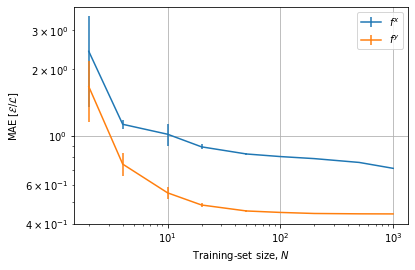

In [ ]:
plt.errorbar(numdata, maes_x.T[0], yerr=maes_x.T[1], label='$f^x$')
plt.errorbar(numdata, maes_y.T[0], yerr=maes_y.T[1], label='$f^y$')
plt.xlabel("Training-set size, $N$")
plt.ylabel("MAE [$\mathcal{E}/\mathcal{L}$]")
plt.loglog()
plt.grid()
plt.legend();

### ML approach 2: Gradient domain machine learning

We first define the vector representation 
$$
  {\bf q} = \left(\begin{array}
  \,2(x+y)\\ x-y  \end{array}\right)
$$ 
This definition is a little arbitrary and can be changed, as long as we allow for *some* coordinate mixing in the derivatives. We denote the Cartesian coordinates of a sample ${\bf r} = (x,y)$.



In [ ]:
class VectorRep:
  def __init__(self, x, y):
    self.q  = np.array([2.*(x+y), x-y])
    self.dx = np.array([2., 1.])
    self.dy = np.array([2.,-1.])

Learn in the gradient domain
$$
    {\rm Cov}\left(\frac{\partial E({\bf q}_i)}{\partial r^k} , 
    \frac{\partial E({\bf q}_j)}{\partial r^l} \right) = 
    \frac{\partial {\bf q}_i}{\partial r^k} \cdot\frac{\partial^2 K({\bf q}_i,{\bf q}_j)}{\partial {\bf q} \partial {\bf q}}
    \frac{\partial {\bf q}_j}{\partial r^l}
    + \frac{\partial K({\bf q}_i,{\bf q}_j)}{\partial {\bf q}} \cdot \frac{\partial^2 {\bf q}}{\partial r_i^k \partial r_j^l}
$$
where the first term of the rhs (denoted ${\bf K}_{\rm Hess}(q_i^k,q_j^l)$) has dimensions $2N \times 2N$ (in 2D), where $N$ is the number of samples, and the 2nd term is 0 for training points.

Given a Gaussian kernel $K({\bf q}_i,{\bf q}_j) = \exp\left(-\frac{({\bf q}_i - {\bf q}_j)^2}{2\sigma^2}\right)$

\begin{align}
 {\bf K}_{\rm Hess}(q_i^k,q_j^l) &= 
 \frac{\partial {\bf q}_i}{\partial r^k}\cdot\frac{\partial {\bf q}_j}{\partial r^l}  
 \frac{\partial }{\partial {\bf q}} \frac{\partial}{\partial {\bf q}} 
 \exp\left(-\frac{({\bf q}_i - {\bf q}_j)^2}{2\sigma^2}\right) \\
 &= \frac{\partial {\bf q}_i}{\partial r^k}\cdot\frac{\partial {\bf q}_j}{\partial r^l}  
 \frac{1}{\sigma^2}\left(1-\frac{({\bf q}_i - {\bf q}_j)^2}{\sigma^2}\right) \exp\left(-\frac{({\bf q}_i - {\bf q}_j)^2}{2\sigma^2}\right).
\end{align}

We then solve for
$$
     {\bf f} = {\bf \alpha} ({\bf K}_{\rm Hess} + \lambda \mathbb{1})
$$
or, more explicitly,
$$
    \left(\begin{matrix}
        f_1^x\\
        f_1^y\\
        \vdots\\
        f_N^y
    \end{matrix}\right) = 
    \left(\begin{matrix}
        \alpha_1^x\\
        \alpha_1^y\\
        \vdots\\
        \alpha_N^y
    \end{matrix}\right)
    \left(\begin{matrix}
        {\bf K}_{\rm Hess}(r_1^x,r_1^x) + \lambda & 
            {\bf K}_{\rm Hess}(r_1^x,r_1^y) & \cdots &
            {\bf K}_{\rm Hess}(r_1^x,r_N^y)\\
        {\bf K}_{\rm Hess}(r_1^y,r_1^x) &
        {\bf K}_{\rm Hess}(r_1^y,r_1^y) + \lambda\\
        \vdots&&\ddots\\
        {\bf K}_{\rm Hess}(r_N^y,r_1^x)&&
        &{\bf K}_{\rm Hess}(r_N^y,r_N^y) + \lambda
    \end{matrix}\right)
$$

In [ ]:
class GPRGradientDomain2D(GPR):
  def build_matrix(self, X1, X2):
    Q1 = np.array([x.q for x in X1]).reshape((2*len(X1),1))
    Q2 = np.array([x.q for x in X2]).reshape((2*len(X2),1))
    gradQ1 = np.array([[x.dx, x.dy] for x in X1]).reshape((2*len(X1),2))
    gradQ2 = np.array([[x.dx, x.dy] for x in X2]).reshape((2*len(X2),2))
    outer = np.tensordot(gradQ1, gradQ2, axes=([1],[1]))
    pairs = cdist(Q1, Q2, 'euclidean')**2 / (self.sigma**2)
    return outer / self.sigma**2 * (1. - pairs) * np.exp( - pairs/2.)

  def train_model(self):
    # We redefine this method to include the extra factor of 2 in the size of I
    matrix = self.build_matrix(self.X_train,self.X_train) \
            + self.lambd * np.identity(2 * len(self.X_train))
    self.alpha = np.dot(self.y_train.flatten(), np.linalg.inv( matrix ))

In [ ]:
class AnalyzeMLModel2D(AnalyzeMLModel):
  def run(self, number_models):
    maes = []
    for i in range(number_models):
      # Evaluate maximum 10,000 points
      idxs = np.random.randint(0, len(self.y), min(10000, len(self.y)))
      frac = self.n/len(idxs)
      X_train, X_test, y_train, y_test = \
          train_test_split(self.X[idxs], self.y[idxs], 
                           train_size=frac, shuffle=True)
      self.gpr.add_training(X_train, y_train)
      self.gpr.train_model()
      maes.append(self.gpr.return_mae(X_test, y_test.flatten()))
    return np.mean(maes), scipy.stats.sem(maes)

In [ ]:
numdata = [2,4,10,20,50,100,200,500,1000]
maes_gd = np.zeros((len(numdata),2))
for i,n in enumerate(numdata):
  X_input = np.array([VectorRep(dyn.data_x[j], dyn.data_y[j]) for j in range(len(dyn.data_x))])
  # Interweave the f_x and f_y target properties
  y_input = np.empty((2*len(dyn.data_x)))
  y_input[0::2] = dyn.data_fx
  y_input[1::2] = dyn.data_fy
  y_input = y_input.reshape((len(dyn.data_x),2))
  analysis = AnalyzeMLModel2D(X_input, y_input, n, GPRGradientDomain2D(100., 1e-7))
  maes_gd[i] = analysis.run(10)

This will take a minute...

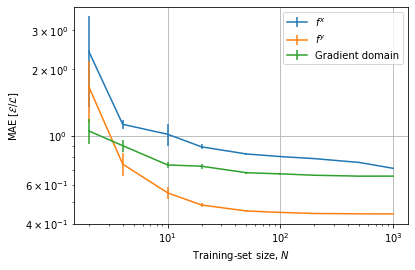

In [ ]:
plt.errorbar(numdata, maes_x.T[0], yerr=maes_x.T[1], label='$f^x$')
plt.errorbar(numdata, maes_y.T[0], yerr=maes_y.T[1], label='$f^y$')
plt.errorbar(numdata, maes_gd.T[0], yerr=maes_gd.T[1], label='Gradient domain')
plt.xlabel("Training-set size, $N$")
plt.ylabel("MAE [$\mathcal{E}/\mathcal{L}$]")
plt.loglog()
plt.grid()
plt.legend();

Results: learning in the gradient domain is sitting between the two components, $f^x$ and $f^y$. The results are larger in the small data regime: incorporating physics in the ML model helps generalize even for low data. The improvements are moderate though statistically significant, mainly because the problem is low dimensional. However, the surface does ensure energy conservation, which is extremely useful, especially when sampling in the microcanonical ensemble (constant energy).



---
# Exercises



### ML approach 3: covariant kernel

One can show that integrating a scalar Gaussian kernel over all rotation matrices yields a simple expression of the form
$$
  K_{\rm c}({\bf r}, {\bf r}') = \exp\left( - \frac{r^2+r'^2}{4\sigma^2}\right) {\bf r} \otimes {\bf r}',
$$
where the last term is a tensor product between the two vectors. (This is a simplified form, but captures its essence. The full expression can be found in `Glielmo, A., Sollich, P., & De Vita, A. (2017). Accurate interatomic force fields via machine learning with covariant kernels. Physical Review B, 95(21), 214302`.

Not only does this covariant kernel correctly handles rotations in 3D space (i.e., it integrates over the SO(3) rotation group), it is *also* energy conserving. The energy conservation can simply be seen by the symmetry of flipping between ${\bf r}$ and ${\bf r}'$. 

1. Implement `ML Approach 3` on covariant kernels. How does it compare to the gradient-domain ML model?

2. For each ML approach, plot $f^x$ and $f^y$ over the space spanned by 
```
X = np.linspace(-4,4,100)
Y = np.linspace(-6,6,100)
```
by predicting each component from the ML model. To focus on differences in the low-data regime, train models with 10 training points each. What did it learn?


3. Let's calculate the curl of our vector field. An energy conserving force field has the property
$$
  \nabla \times {\bf F} = 0
$$
Check that the `ML Approach 3` satisfies this condition.

Hint: There is no function in `numpy` that offers the direct calculation of the curl. Note however that you can use `np.gradient` to compute elements of the Jacobian matrix, $J_{ij} = \frac{\partial F_i} {\partial x_j}$.